## Imports

In [1]:
import os
import shutil
import typing
import random

import tqdm
import torch
import numpy
import pandas
import torchvision
import matplotlib.pyplot as plt
import pytorch_metric_learning.utils
import pytorch_metric_learning.miners
import pytorch_metric_learning.losses
import pytorch_metric_learning.samplers
from torchvision.transforms import v2 as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


## Load the small-faces dataset

Удалим людей, для которых дана только одна картинка. Этого однозначно недостаточно для решения задачи классификации лиц. После этого вручную выделим несколько классов в тестовую выборку.

In [2]:
for subdir, dirs, files in os.walk("dataset2"):
    if len(files) == 1:
        shutil.move(subdir, subdir.replace("training", "removed"))

In [3]:
train_images = torchvision.datasets.ImageFolder("dataset2/training")
test_images = torchvision.datasets.ImageFolder("dataset2/testing")

If dataset in cell above too easy for, you can try http://vis-www.cs.umass.edu/lfw/lfw.tgz



## Create dataset & dataloader classes

### Dataset class

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            name: str,
            dataset: torchvision.datasets.ImageFolder,
            preload: bool = True,
            precalculate_transform: bool = True,
            transform: typing.Optional[transforms.Compose] = None
        ):
        self.name = name
        self.transform = None
        self.dataset = dataset
        self.classes = dataset.classes
        self.precalculated_transform = None

        # The dataset is not that big, so we might want to load it into RAM beforehand
        if preload or precalculate_transform:
            if precalculate_transform:
                # We might also want to precalculate the transform
                self.precalculated_transform = transform
                self.transform = transform
                transform = None
            # If precalculate_transform is True, self.transform is set, and __getitem__ will apply the transforms
            self.images, self.targets = self.load_all("Preload {}".format(self.name))
        # If precalculate_transform is True, this will be None
        self.transform = transform

    def load_all(self, progress_bar: bool = False):
        images = [ ]
        targets = [ ]
        for record in (tqdm.tqdm(self, desc = progress_bar.ljust(25)) if progress_bar else self):
            images.append(record[0])
            targets.append(record[1])
        # If no transforms are applied, torch.stack(images) will fail
        try: return torch.stack(images), targets
        except: return images, targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if hasattr(self, 'images') and hasattr(self, 'targets'):
            # If the data has been preloaded, use it
            image, target = self.images[idx], self.targets[idx]
        else:
            # Access the source
            image, target = self.dataset[idx]
        # Apply the transform if needed
        if self.transform is not None:
            image = self.transform(image)
        return image, target
    
    def channel_stats(self):
        images, _ = self.load_all() # Get the dataset as two tensors
        # Calculate the metrics
        mean = torch.mean(images, dim = [0, 2, 3])
        std = torch.std(images, dim = [0, 2, 3])
        return mean, std

### Calculate mean and std

In [5]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((250, 250), antialias = True),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
mean, std = train_set.channel_stats()
print(mean, std)
del train_set

Preload train            : 100%|██████████| 9143/9143 [00:36<00:00, 249.83it/s]


tensor([0.4365, 0.3805, 0.3393]) tensor([0.2973, 0.2726, 0.2667])


### Create datasets

In [6]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((250, 250), antialias = True),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
test_set = MyDataset("test", test_images, transform = transform, preload = True, precalculate_transform = True)

Preload test             : 100%|██████████| 21/21 [00:00<00:00, 198.11it/s]


In [7]:
print("Train classes count", len(train_set.classes))
print("Test classes count", len(test_set.classes))
print("Images size", train_set[0][0].shape)
print("Train size", len(train_set))
print("Test size", len(test_set))

Train classes count 1675
Test classes count 5
Images size torch.Size([3, 250, 250])
Train size 9143
Test size 21


### Display examples

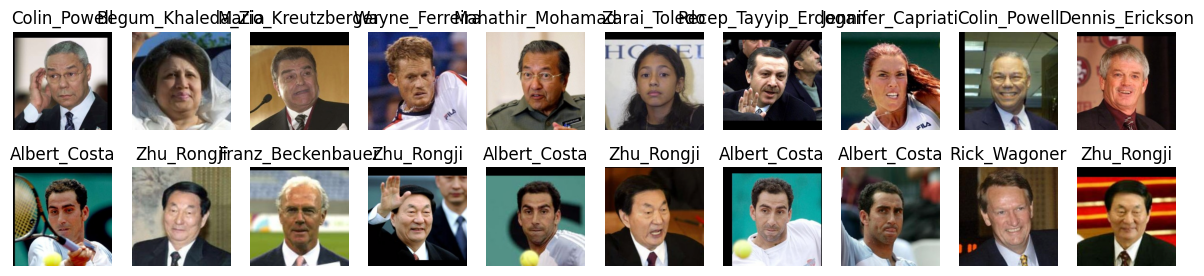

In [8]:
fix_random()

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = torch.zeros_like(mean), std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = torch.ones_like(std))
])

# Display some samples from each dataset
def display_examples(dataset: torch.utils.data.Dataset, row: int):

    train_loader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(dataset.classes[label]))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8))

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

### Crop

На фотографиях явно слишком много лишней информации. Попробуем добавить Crop, чтобы лицо занимало большую часть картинки.

In [9]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((250, 250), antialias = True),
    torchvision.transforms.v2.CenterCrop((128, 128)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
mean, std = train_set.channel_stats()
print(mean, std)

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = torch.zeros_like(mean), std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = torch.ones_like(std))
])

Preload train            : 100%|██████████| 9143/9143 [00:06<00:00, 1492.10it/s]


tensor([0.5569, 0.4341, 0.3573]) tensor([0.2503, 0.2150, 0.2071])


Preload test             : 100%|██████████| 21/21 [00:00<00:00, 777.81it/s]


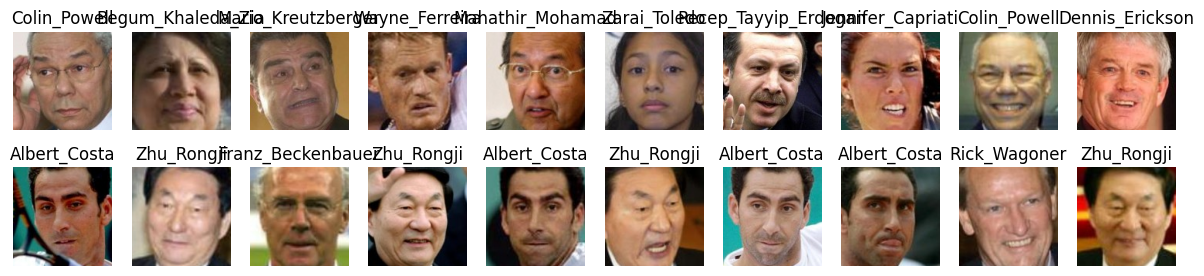

In [10]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((250, 250), antialias = True),
    torchvision.transforms.v2.CenterCrop((128, 128)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

train_set = MyDataset("train", train_images, transform = transform, preload = True, precalculate_transform = True)
test_set = MyDataset("test", test_images, transform = transform, preload = True, precalculate_transform = True)

fix_random()
plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

In [11]:
print("Train classes count", len(train_set.classes))
print("Test classes count", len(test_set.classes))
print("Images size", train_set[0][0].shape)
print("Train size", len(train_set))
print("Test size", len(test_set))

Train classes count 1675
Test classes count 5
Images size torch.Size([3, 128, 128])
Train size 9143
Test size 21


### Create balanced dataloaders

In [12]:
def show_class_distribtion(labels, classes):
    plt.figure(figsize = (10, 3))
    x, counts = labels.unique(return_counts = True)
    plt.bar(numpy.array(classes)[x], height = counts)

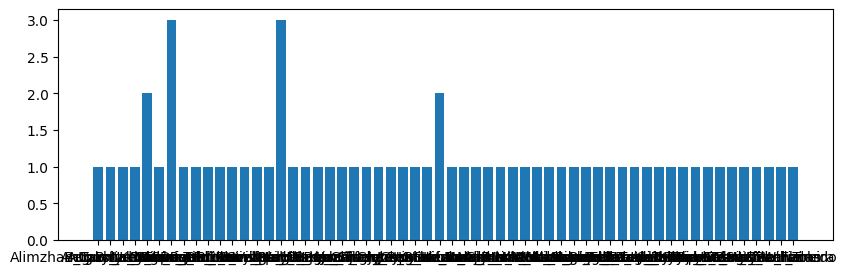

In [13]:
fix_random()
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True)
show_class_distribtion(next(iter(train_loader))[1], train_set.classes)

Случайная выборка очень несбалансирована. Это не подходит для обучения модели на триплетную функцию потерь. Воспользуемся семплером, чтобы в батчах получалось одинаковое количество объектов каждого класса

105

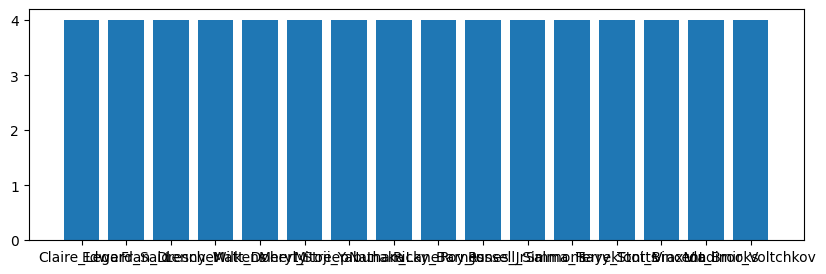

In [14]:
fix_random()
N_EPOCHS = 25
LENGTH_BEFORE_NEW_ITER = 7000
train_mpc_sampler = pytorch_metric_learning.samplers.MPerClassSampler(labels = train_set.targets, m = 4, length_before_new_iter = LENGTH_BEFORE_NEW_ITER)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, sampler = train_mpc_sampler)
show_class_distribtion(next(iter(train_loader))[1], train_set.classes)
len(train_loader)

Это гораздо лучше. \
\
Тестовая выборка достаточно маленькая, поэтому будем загружать её целиком в одном батче.

1

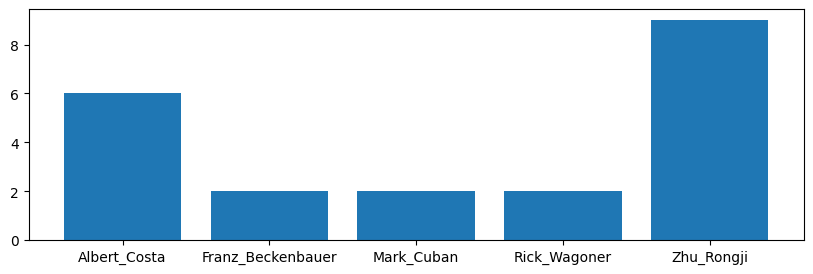

In [15]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size = len(test_set))
show_class_distribtion(next(iter(test_loader))[1], test_set.classes)
len(test_loader)

## Define the model for embedding extraction

In [16]:
EMBEDDING_SIZE = 256 # Embeddings of length 256 should be good enough

In [17]:
def MyModel():
    return torchvision.models.resnet50(num_classes = EMBEDDING_SIZE)

model = MyModel()
model(next(iter(test_loader))[0]).shape

torch.Size([21, 256])

## Train the model

In [18]:
MARGIN = 1 # Standard value in PyTorch TripletMarginLoss, should be good

Будем обучать модель на TripletMarginLoss библиотеки pytorch_metric_learning. Для этого необходимо разделять элементы батча на триплеты, для чего воспользуемся TripletMarginMiner.

In [19]:
fix_random()
train_miner = pytorch_metric_learning.miners.TripletMarginMiner(margin = MARGIN, type_of_triplets = "all")

images, labels = next(iter(train_loader))
embeddings = model(images)
print(embeddings.shape)

indices = train_miner(embeddings, labels)
print(len(indices), indices[0].shape, indices[1].shape, indices[2].shape)

torch.Size([64, 256])
3 torch.Size([11520]) torch.Size([11520]) torch.Size([11520])


In [20]:
criterion = pytorch_metric_learning.losses.TripletMarginLoss(margin = MARGIN)
loss = criterion(embeddings, labels, indices)
print(loss)

tensor(0.8623, grad_fn=<MeanBackward0>)


In [21]:
del images
del labels
del embeddings
del indices
del loss

Для валидации результата будем использовать метрики, вычисляемые AccuracyCalculator библиотеки pytorch_metric_learning. Посмотрим на значения метрик необученной модели.

In [22]:
metrics = pytorch_metric_learning.utils.accuracy_calculator.AccuracyCalculator()
def validate(model: torch.nn.Module, device: torch.device) -> dict:
    with torch.no_grad():
        images, targets = next(iter(test_loader))
        model = model.to(device)
        model.eval()
        embeddings = model(images.to(device))
        return metrics.get_accuracy(embeddings, targets.to(device))

validate(model, device)

d:\Programs\Programming\Python\lib\site-packages\faiss\contrib\torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


{'AMI': 0.0911827740756235,
 'NMI': 0.3555167896654628,
 'mean_average_precision': 0.4862702774388698,
 'mean_average_precision_at_r': 0.25762896825396825,
 'mean_reciprocal_rank': 0.6254033446311951,
 'precision_at_1': 0.47619047619047616,
 'r_precision': 0.32261904761904764}

In [23]:
def train(model: torch.nn.Module, n_epochs: int, device: torch.device) -> None:
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    for epoch in range(n_epochs):
        sum_loss = 0
        for (images, targets) in tqdm.tqdm(train_loader, desc = 'Epoch {}'.format(epoch + 1)):
            if len(targets) == 0:
                continue
            model.train() # Enter train mode
            optimizer.zero_grad() # Zero gradients
            embeddings = model(images.to(device))
            indices = train_miner(embeddings, targets)
            loss = criterion(embeddings, targets.to(device), indices)
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights
            sum_loss += loss.item()
        train_loss = sum_loss / len(train_loader)
        metrics = validate(model, device)
        mean_avg_pr = metrics['mean_average_precision']
        AMI = metrics['AMI']
        NMI = metrics['NMI']
        print(f"Train loss: {train_loss:.5f}, Test MAP: {mean_avg_pr:.5f}, Test AMI: {AMI:.5f}, Test NMI: {NMI:.5f}")

fix_random()
train(model, N_EPOCHS, device)

Epoch 1: 100%|██████████| 105/105 [00:24<00:00,  4.30it/s]


Train loss: 0.88097, Test MAP: 0.62861, Test AMI: 0.34440, Test NMI: 0.54079


Epoch 2: 100%|██████████| 105/105 [00:23<00:00,  4.46it/s]


Train loss: 0.83814, Test MAP: 0.74657, Test AMI: 0.51322, Test NMI: 0.65794


Epoch 3: 100%|██████████| 105/105 [00:24<00:00,  4.36it/s]


Train loss: 0.78689, Test MAP: 0.66120, Test AMI: 0.30301, Test NMI: 0.51004


Epoch 4: 100%|██████████| 105/105 [00:23<00:00,  4.40it/s]


Train loss: 0.77407, Test MAP: 0.69262, Test AMI: 0.34383, Test NMI: 0.54171


Epoch 5: 100%|██████████| 105/105 [00:24<00:00,  4.36it/s]


Train loss: 0.77116, Test MAP: 0.71237, Test AMI: 0.31608, Test NMI: 0.51583


Epoch 6: 100%|██████████| 105/105 [00:24<00:00,  4.37it/s]


Train loss: 0.73577, Test MAP: 0.76206, Test AMI: 0.51656, Test NMI: 0.65769


Epoch 7: 100%|██████████| 105/105 [00:23<00:00,  4.48it/s]


Train loss: 0.70568, Test MAP: 0.77369, Test AMI: 0.56666, Test NMI: 0.69612


Epoch 8: 100%|██████████| 105/105 [00:23<00:00,  4.49it/s]


Train loss: 0.68933, Test MAP: 0.67419, Test AMI: 0.39300, Test NMI: 0.57579


Epoch 9: 100%|██████████| 105/105 [00:23<00:00,  4.48it/s]


Train loss: 0.66518, Test MAP: 0.80911, Test AMI: 0.43310, Test NMI: 0.59853


Epoch 10: 100%|██████████| 105/105 [00:23<00:00,  4.46it/s]


Train loss: 0.65201, Test MAP: 0.74117, Test AMI: 0.27264, Test NMI: 0.49237


Epoch 11: 100%|██████████| 105/105 [00:23<00:00,  4.51it/s]


Train loss: 0.62978, Test MAP: 0.77911, Test AMI: 0.52944, Test NMI: 0.67002


Epoch 12: 100%|██████████| 105/105 [00:24<00:00,  4.32it/s]


Train loss: 0.62164, Test MAP: 0.63816, Test AMI: 0.08789, Test NMI: 0.35846


Epoch 13: 100%|██████████| 105/105 [00:23<00:00,  4.41it/s]


Train loss: 0.60275, Test MAP: 0.70452, Test AMI: 0.21442, Test NMI: 0.44437


Epoch 14: 100%|██████████| 105/105 [00:23<00:00,  4.45it/s]


Train loss: 0.59571, Test MAP: 0.78001, Test AMI: 0.52930, Test NMI: 0.67109


Epoch 15: 100%|██████████| 105/105 [00:24<00:00,  4.36it/s]


Train loss: 0.58539, Test MAP: 0.67707, Test AMI: 0.39300, Test NMI: 0.57579


Epoch 16: 100%|██████████| 105/105 [00:23<00:00,  4.44it/s]


Train loss: 0.57352, Test MAP: 0.88415, Test AMI: 0.69837, Test NMI: 0.78933


Epoch 17: 100%|██████████| 105/105 [00:23<00:00,  4.45it/s]


Train loss: 0.58482, Test MAP: 0.70404, Test AMI: 0.47890, Test NMI: 0.63632


Epoch 18: 100%|██████████| 105/105 [00:24<00:00,  4.35it/s]


Train loss: 0.57725, Test MAP: 0.75655, Test AMI: 0.49862, Test NMI: 0.64982


Epoch 19: 100%|██████████| 105/105 [00:24<00:00,  4.32it/s]


Train loss: 0.56030, Test MAP: 0.86701, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 20: 100%|██████████| 105/105 [00:23<00:00,  4.40it/s]


Train loss: 0.54550, Test MAP: 0.90422, Test AMI: 0.19751, Test NMI: 0.43776


Epoch 21: 100%|██████████| 105/105 [00:24<00:00,  4.28it/s]


Train loss: 0.54201, Test MAP: 0.62753, Test AMI: 0.29880, Test NMI: 0.50847


Epoch 22: 100%|██████████| 105/105 [00:24<00:00,  4.34it/s]


Train loss: 0.53295, Test MAP: 0.85824, Test AMI: 0.75081, Test NMI: 0.82359


Epoch 23: 100%|██████████| 105/105 [00:23<00:00,  4.39it/s]


Train loss: 0.51891, Test MAP: 0.82343, Test AMI: 0.50491, Test NMI: 0.65282


Epoch 24: 100%|██████████| 105/105 [00:24<00:00,  4.37it/s]


Train loss: 0.50773, Test MAP: 0.87295, Test AMI: 0.69795, Test NMI: 0.78775


Epoch 25: 100%|██████████| 105/105 [00:23<00:00,  4.40it/s]


Train loss: 0.51398, Test MAP: 0.88828, Test AMI: 0.51025, Test NMI: 0.65794


На последних эпохах лосс практически не уменьшается. Кажется, модель можно улучшить. Попробуем при обучении использовать не все триплеты, а только относительно "сложные".

In [24]:
fix_random()
train_miner = pytorch_metric_learning.miners.TripletMarginMiner(margin = MARGIN, type_of_triplets = "semihard")
train(model, N_EPOCHS, device)

Epoch 1: 100%|██████████| 105/105 [00:23<00:00,  4.40it/s]


Train loss: 0.40331, Test MAP: 0.85022, Test AMI: 0.49125, Test NMI: 0.64441


Epoch 2: 100%|██████████| 105/105 [00:24<00:00,  4.32it/s]


Train loss: 0.39737, Test MAP: 0.88250, Test AMI: 0.23747, Test NMI: 0.46576


Epoch 3: 100%|██████████| 105/105 [00:24<00:00,  4.27it/s]


Train loss: 0.39987, Test MAP: 0.90465, Test AMI: 0.62522, Test NMI: 0.73739


Epoch 4: 100%|██████████| 105/105 [00:24<00:00,  4.33it/s]


Train loss: 0.39364, Test MAP: 0.88049, Test AMI: 0.54766, Test NMI: 0.67966


Epoch 5: 100%|██████████| 105/105 [00:24<00:00,  4.36it/s]


Train loss: 0.38339, Test MAP: 0.85247, Test AMI: 0.46522, Test NMI: 0.62654


Epoch 6: 100%|██████████| 105/105 [00:24<00:00,  4.34it/s]


Train loss: 0.38324, Test MAP: 0.84074, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 7: 100%|██████████| 105/105 [00:23<00:00,  4.43it/s]


Train loss: 0.37974, Test MAP: 0.88622, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 8: 100%|██████████| 105/105 [00:24<00:00,  4.34it/s]


Train loss: 0.38095, Test MAP: 0.88269, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 9: 100%|██████████| 105/105 [00:24<00:00,  4.25it/s]


Train loss: 0.37528, Test MAP: 0.90687, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 10: 100%|██████████| 105/105 [00:24<00:00,  4.32it/s]


Train loss: 0.37291, Test MAP: 0.87616, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 11: 100%|██████████| 105/105 [00:24<00:00,  4.33it/s]


Train loss: 0.36706, Test MAP: 0.85072, Test AMI: 0.57402, Test NMI: 0.70248


Epoch 12: 100%|██████████| 105/105 [00:24<00:00,  4.32it/s]


Train loss: 0.37152, Test MAP: 0.82946, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 13: 100%|██████████| 105/105 [00:24<00:00,  4.29it/s]


Train loss: 0.36676, Test MAP: 0.89712, Test AMI: 0.60492, Test NMI: 0.72327


Epoch 14: 100%|██████████| 105/105 [00:24<00:00,  4.34it/s]


Train loss: 0.36204, Test MAP: 0.87176, Test AMI: 0.62821, Test NMI: 0.73680


Epoch 15: 100%|██████████| 105/105 [00:23<00:00,  4.48it/s]


Train loss: 0.36309, Test MAP: 0.87384, Test AMI: 0.57402, Test NMI: 0.70248


Epoch 16: 100%|██████████| 105/105 [00:23<00:00,  4.39it/s]


Train loss: 0.36168, Test MAP: 0.91378, Test AMI: 0.69837, Test NMI: 0.78933


Epoch 17: 100%|██████████| 105/105 [00:24<00:00,  4.35it/s]


Train loss: 0.35440, Test MAP: 0.88961, Test AMI: 0.61372, Test NMI: 0.73021


Epoch 18: 100%|██████████| 105/105 [00:23<00:00,  4.39it/s]


Train loss: 0.35190, Test MAP: 0.96651, Test AMI: 0.57230, Test NMI: 0.69711


Epoch 19: 100%|██████████| 105/105 [00:24<00:00,  4.33it/s]


Train loss: 0.35015, Test MAP: 0.91380, Test AMI: 0.62821, Test NMI: 0.73680


Epoch 20: 100%|██████████| 105/105 [00:24<00:00,  4.30it/s]


Train loss: 0.34447, Test MAP: 0.95379, Test AMI: 0.70692, Test NMI: 0.79455


Epoch 21: 100%|██████████| 105/105 [00:24<00:00,  4.27it/s]


Train loss: 0.34669, Test MAP: 0.88583, Test AMI: 0.64351, Test NMI: 0.74673


Epoch 22: 100%|██████████| 105/105 [00:24<00:00,  4.31it/s]


Train loss: 0.33938, Test MAP: 0.91100, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 23: 100%|██████████| 105/105 [00:24<00:00,  4.27it/s]


Train loss: 0.34329, Test MAP: 0.89477, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 24: 100%|██████████| 105/105 [00:24<00:00,  4.31it/s]


Train loss: 0.34525, Test MAP: 0.93791, Test AMI: 0.68992, Test NMI: 0.78362


Epoch 25: 100%|██████████| 105/105 [00:24<00:00,  4.31it/s]


Train loss: 0.34004, Test MAP: 0.90847, Test AMI: 0.62656, Test NMI: 0.73940


## Calculate metrics

In [33]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
validate(model, device)

{'AMI': 0.6265555672558626,
 'NMI': 0.7394025239011109,
 'mean_average_precision': 0.9084656084656083,
 'mean_average_precision_at_r': 0.8476190476190476,
 'mean_reciprocal_rank': 0.9100528955459595,
 'precision_at_1': 0.8571428571428571,
 'r_precision': 0.8476190476190476}

Судя по значениям метрик, результат получился очень хороший

## Display the results

You can use faiss: https://github.com/facebookresearch/faiss

Посмотрим на реальные результаты. Вычислим эмбеддинги для тестовых данных.

In [35]:
images, labels = next(iter(test_loader))
labels = numpy.array(test_set.classes)[labels]
with torch.no_grad():
    embeddings = model(images.to(device))

Посмотрим на распределение Евклидового расстояний между эмбеддингами.

In [36]:
matrix = [ [ "-1" ] * len(test_set) for i in range(len(test_set)) ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        matrix[i][j] = "{0:.2f}".format(euc_dist)

pandas.options.display.max_columns = 30
df = pandas.DataFrame(matrix, columns = labels.tolist())
df.index = labels.tolist()
df

,Albert_Costa,Albert_Costa,Albert_Costa,Albert_Costa,Albert_Costa,Albert_Costa,Franz_Beckenbauer,Franz_Beckenbauer,Mark_Cuban,Mark_Cuban,Rick_Wagoner,Rick_Wagoner,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji
Albert_Costa,0.00,265.37,339.48,312.46,308.69,241.77,1445.60,1045.30,648.67,716.15,1071.02,817.77,776.74,956.40,837.94,894.74,781.38,712.47,838.37,883.52,843.82
Albert_Costa,265.37,0.00,475.78,121.48,252.95,157.88,1548.97,1102.19,644.04,767.60,1128.01,706.97,693.16,896.31,797.56,782.21,706.84,594.81,761.22,795.36,749.60
Albert_Costa,339.48,475.78,0.00,468.87,578.29,522.30,1168.36,759.92,544.25,593.93,806.80,678.86,787.44,957.18,745.11,965.51,754.71,762.83,884.80,899.46,865.63
Albert_Costa,312.46,121.48,468.87,0.00,241.48,238.38,1529.40,1055.56,685.65,829.41,1062.43,643.88,664.15,875.79,765.11,763.00,661.50,557.62,729.00,776.98,686.92
Albert_Costa,308.69,252.95,578.29,241.48,0.00,239.70,1668.49,1216.34,860.64,978.98,1201.25,861.13,784.25,978.46,914.97,852.81,792.80,674.79,809.69,895.25,780.93
Albert_Costa,241.77,157.88,522.30,238.38,239.70,0.00,1562.04,1153.69,664.20,794.28,1178.49,813.34,670.02,854.99,795.33,740.44,699.96,579.78,717.70,764.22,737.39
Franz_Beckenbauer,1445.60,1548.97,1168.36,1529.40,1668.49,1562.04,0.00,620.61,1089.59,1140.56,752.08,1243.53,1290.68,1276.60,1050.32,1476.27,1226.77,1391.46,1380.55,1314.49,1387.25
Franz_Beckenbauer,1045.30,1102.19,759.92,1055.56,1216.34,1153.69,620.61,0.00,812.78,912.38,225.61,680.97,971.02,1050.34,767.18,1170.96,879.51,1017.14,1073.25,1036.10,1004.99
Mark_Cuban,648.67,644.04,544.25,685.65,860.64,664.20,1089.59,812.78,0.00,308.44,956.89,682.94,664.69,777.42,590.67,812.43,675.65,692.78,800.27,704.18,858.58
Mark_Cuban,716.15,767.60,593.93,829.41,978.98,794.28,1140.56,912.38,308.44,0.00,1077.39,857.78,961.45,1075.38,882.84,1107.30,969.30,978.28,1091.05,1007.01,1144.33


![Alternative Text][1702132381143]

[1702132381143]: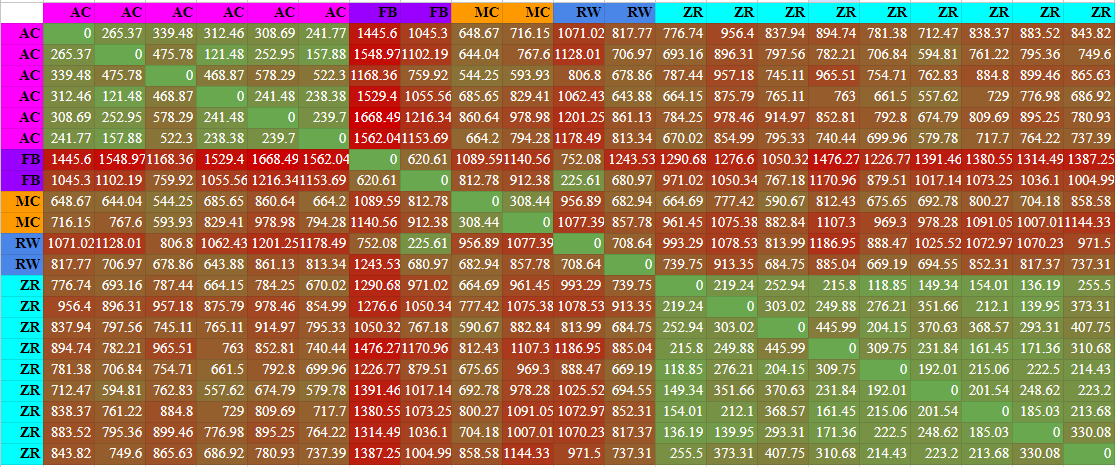

Результат выглядит достаточно хорошо: расстояния между эмбеддингами картинок одного человека заметно меньше расстояний между эмбеддингами разных людей.

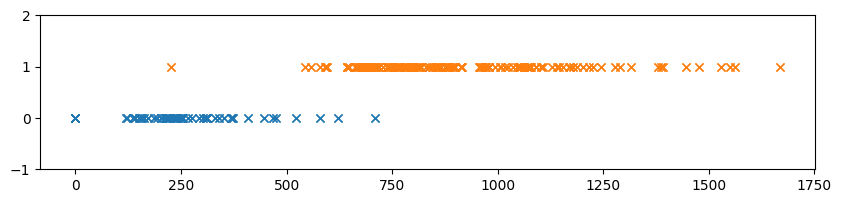

In [37]:
correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        if label1 == label2: correct_dists.append(euc_dist)
        else: incorrect_dists.append(euc_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')

Явно видно, что расстояния между объектами одного класса и объектами разных классов хорошо разделимы. Все "хорошие" расстояния меньше 150, а "плохие" - больше. Таким образом, на тестовой выборке модель работает идеально. \
 \
Для интереса проведем аналогичный анализ с использованием косинусного расстояния.

In [38]:
matrix = [ [ "-1" ] * len(test_set) for i in range(len(test_set)) ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        matrix[i][j] = "{0:.2f}".format(cos_dist)

pandas.options.display.max_columns = 30
df = pandas.DataFrame(matrix, columns = labels.tolist())
df.index = labels.tolist()
df

,Albert_Costa,Albert_Costa,Albert_Costa,Albert_Costa,Albert_Costa,Albert_Costa,Franz_Beckenbauer,Franz_Beckenbauer,Mark_Cuban,Mark_Cuban,Rick_Wagoner,Rick_Wagoner,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji,Zhu_Rongji
Albert_Costa,1.00,0.92,0.91,0.88,0.93,0.95,-0.58,-0.69,0.44,0.46,-0.64,-0.05,0.31,0.18,0.03,0.35,0.22,0.43,0.34,0.25,0.25
Albert_Costa,0.92,1.00,0.73,0.99,0.95,0.98,-0.77,-0.81,0.47,0.39,-0.76,0.27,0.47,0.30,0.16,0.52,0.39,0.61,0.47,0.41,0.43
Albert_Costa,0.91,0.73,1.00,0.66,0.73,0.75,-0.38,-0.54,0.39,0.56,-0.56,-0.28,-0.04,-0.14,-0.27,-0.02,-0.15,0.05,-0.02,-0.10,-0.14
Albert_Costa,0.88,0.99,0.66,1.00,0.97,0.95,-0.85,-0.83,0.33,0.24,-0.71,0.32,0.47,0.29,0.14,0.53,0.41,0.64,0.49,0.40,0.49
Albert_Costa,0.93,0.95,0.73,0.97,1.00,0.95,-0.79,-0.80,0.24,0.17,-0.63,0.14,0.44,0.27,0.11,0.49,0.38,0.59,0.48,0.35,0.48
Albert_Costa,0.95,0.98,0.75,0.95,0.95,1.00,-0.66,-0.76,0.51,0.41,-0.71,0.15,0.56,0.41,0.27,0.60,0.47,0.67,0.56,0.50,0.50
Franz_Beckenbauer,-0.58,-0.77,-0.38,-0.85,-0.79,-0.66,1.00,0.84,0.06,0.11,0.64,-0.45,-0.21,-0.01,0.12,-0.28,-0.19,-0.41,-0.23,-0.13,-0.33
Franz_Beckenbauer,-0.69,-0.81,-0.54,-0.83,-0.80,-0.76,0.84,1.00,-0.21,-0.13,0.90,-0.04,-0.40,-0.24,-0.12,-0.43,-0.33,-0.52,-0.39,-0.32,-0.36
Mark_Cuban,0.44,0.47,0.39,0.33,0.24,0.51,0.06,-0.21,1.00,0.91,-0.54,0.12,0.43,0.42,0.43,0.43,0.32,0.39,0.34,0.49,0.13
Mark_Cuban,0.46,0.39,0.56,0.24,0.17,0.41,0.11,-0.13,0.91,1.00,-0.49,-0.01,0.04,0.03,0.04,0.05,-0.08,0.02,-0.05,0.09,-0.26


![Alternative Text][1702132477930]

[1702132477930]: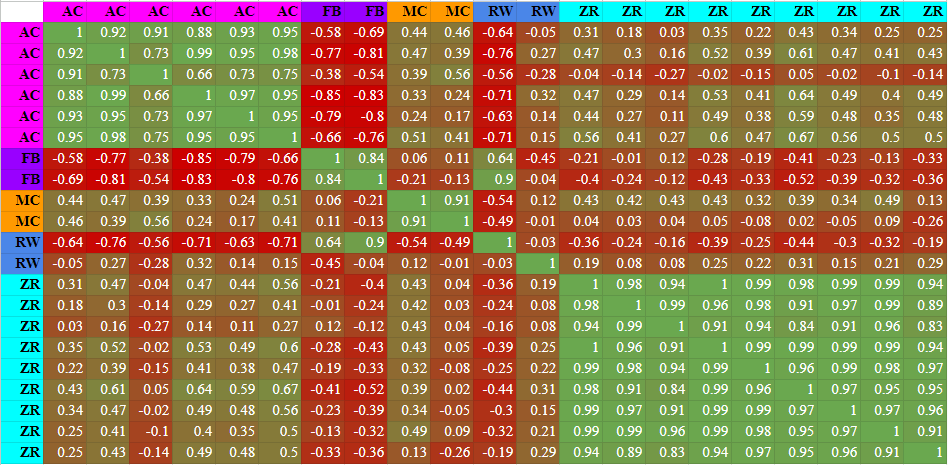

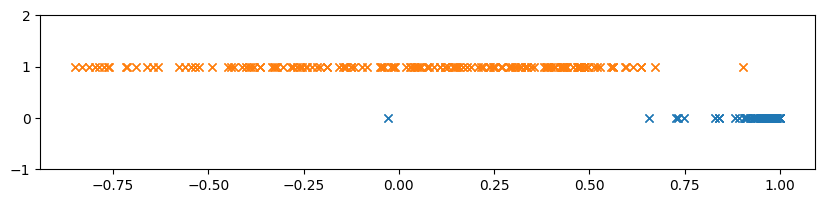

In [39]:
correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(embeddings, labels)):
    for j, (emb2, label2) in enumerate(zip(embeddings, labels)):
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        if label1 == label2: correct_dists.append(cos_dist)
        else: incorrect_dists.append(cos_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')

Результат аналогичен: на тестовой выборке модель работает идеально. \
 \
Выберем несколько объектов, чтобы посмотреть на сами картинки.

In [41]:
embeddings = [ embeddings[0], embeddings[1], embeddings[2], embeddings[6], embeddings[8], embeddings[10] ]
images = [ images[0], images[1], images[2], images[6], images[8], images[10] ]
labels = [ labels[0], labels[1], labels[2], labels[6], labels[8], labels[10] ]

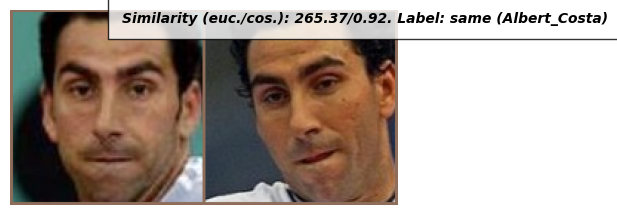

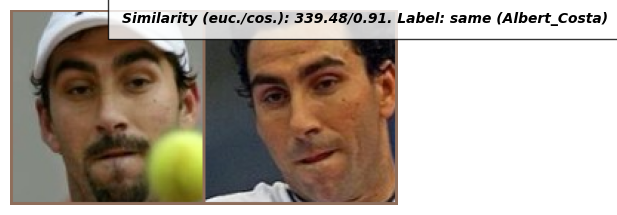

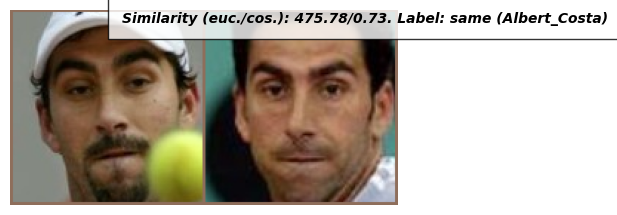

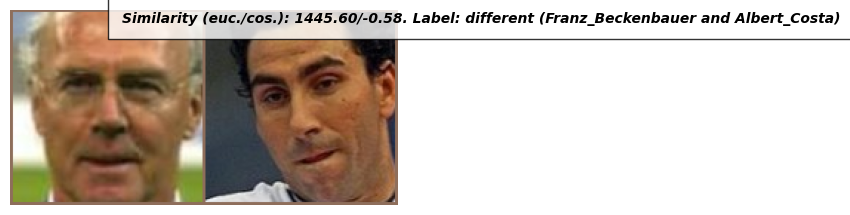

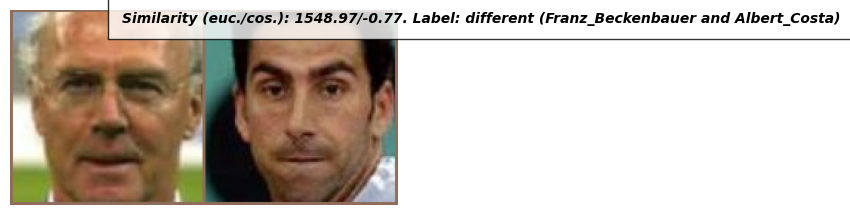

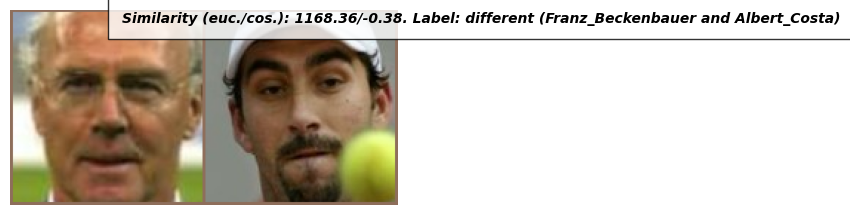

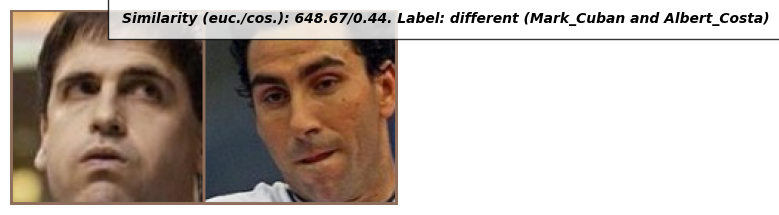

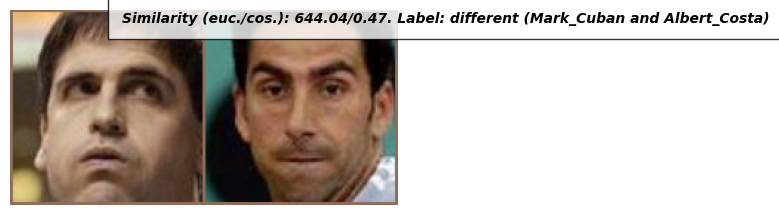

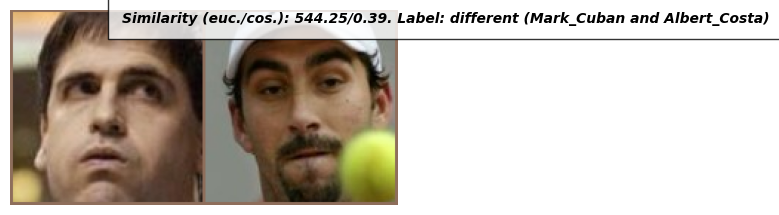

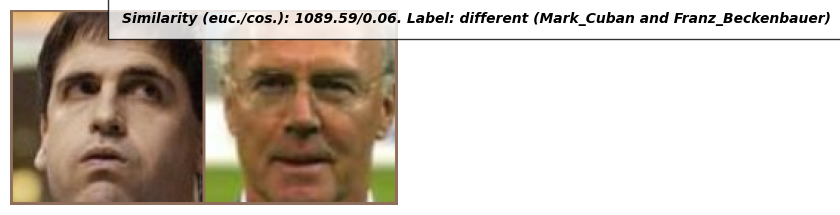

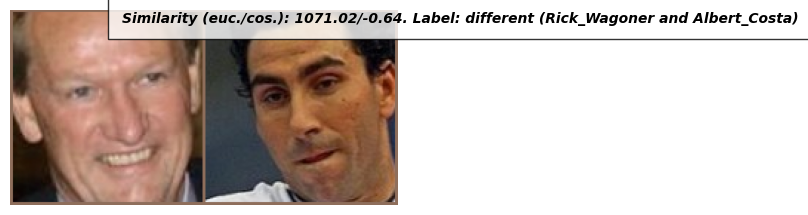

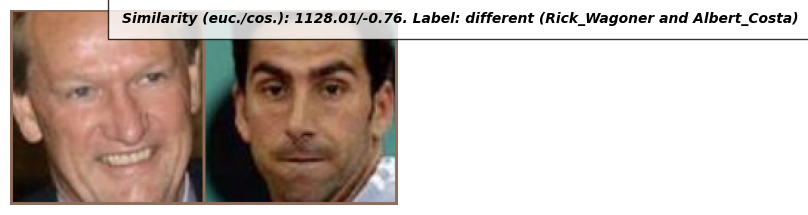

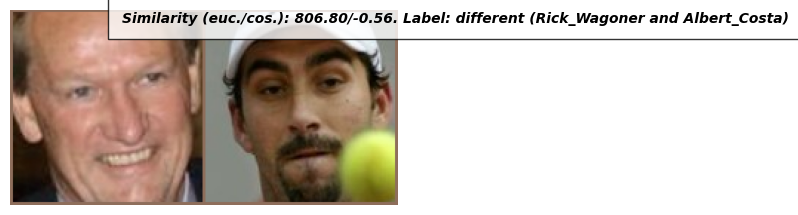

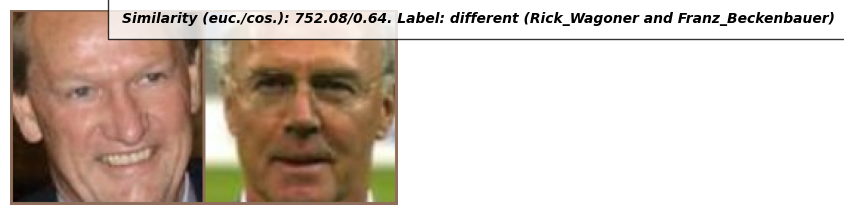

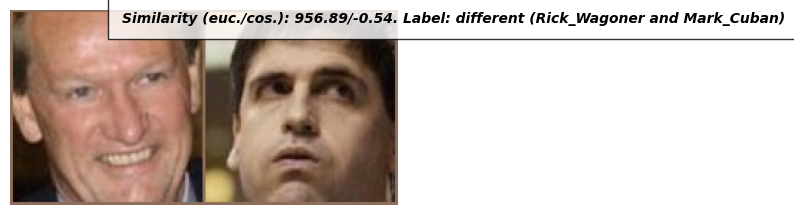

In [44]:
def imshow(img, text):
    plt.axis("off")
    plt.rcParams["figure.figsize"] = (5, 5)
    plt.imshow((denormalize(img).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8), cmap = 'gray')
    plt.text(75, 8, text, style = 'italic', fontweight = 'bold', bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 10 })
    plt.show()

for i, (emb1, img1, label1) in enumerate(zip(embeddings, images, labels)):
    for j, (emb2, img2, label2) in enumerate(zip(embeddings, images, labels)):
        if i <= j:
            continue
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        
        concatenated = torch.stack((img1, img2))
        label = "same ({})".format(label1) if label1 == label2 else "different ({} and {})".format(label1, label2)
        imshow(torchvision.utils.make_grid(concatenated), 'Similarity (euc./cos.): {:.2f}/{:.2f}. Label: {}'.format(euc_dist, cos_dist, label))

## Place for conclusion

Таким образом, данный датасет очень простой. Достаточно маленькая модель (ResNet-50) после обучения на триплетную функцию потерь извлекает эмбеддинги, позволяющие идеально определять, являются ли две картинки фотографиями одного человека. И анализ результатов это подтверждает: Евклидово расстояние между эмбедингами фотографий одного человека всегда меньше 150, а разных людей - больше 150; косинусное расстояние между эмбеддингами фотографий одного человека больше 0.75, а разных людей - меньше. И все вычисленные метрики, соответственно, равны единице.